In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima.arima import auto_arima

In [5]:
data= pd.read_csv("/kaggle/input/delhi-air-quality/delhi_aqi.csv",index_col = "date",parse_dates=True)
data.rename(columns={"pm2_5": "PM2.5"}, inplace=True)
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (18776, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18776 entries, 2020-11-25 01:00:00 to 2023-01-24 08:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co      18776 non-null  float64
 1   no      18776 non-null  float64
 2   no2     18776 non-null  float64
 3   o3      18776 non-null  float64
 4   so2     18776 non-null  float64
 5   PM2.5   18776 non-null  float64
 6   pm10    18776 non-null  float64
 7   nh3     18776 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None


,co,no,no2,o3,so2,PM2.5,pm10,nh3
date,,,,,,,,
2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


##### Creating a new dataframe with only the interested column


In [6]:
df = data.filter(["PM2.5"], axis = 1)
df.head(5)

,PM2.5
date,
2020-11-25 01:00:00,364.61
2020-11-25 02:00:00,420.96
2020-11-25 03:00:00,463.68
2020-11-25 04:00:00,454.81
2020-11-25 05:00:00,448.14


The data had no missing values and from the boxplot below, we can clearly see the presence of outliers. All outliers shall be included.

In [7]:
df.isna().sum()

PM2.5    0
dtype: int64

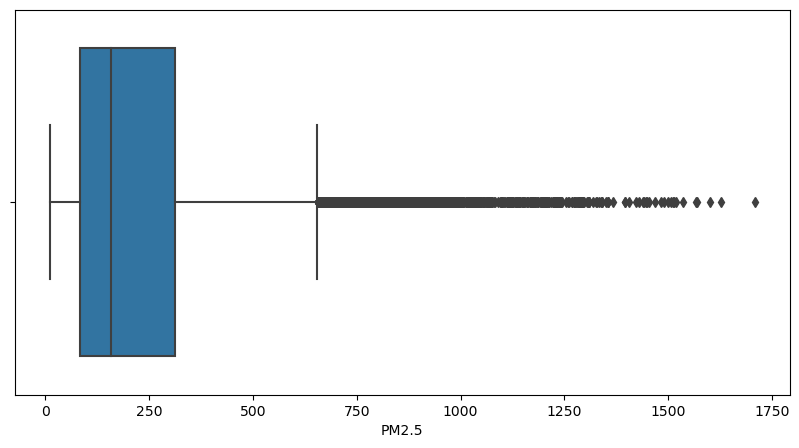

In [14]:
fig = plt.figure(figsize = (10,5))
sns.boxplot(x=df["PM2.5"]);

##### Checking for Stationarity
From the graph below we can't really tell if the Time series data is stationary as it is more compact, hence I shall plot the **ACF plot** and run some **Statistical Tests for Stationarity**.

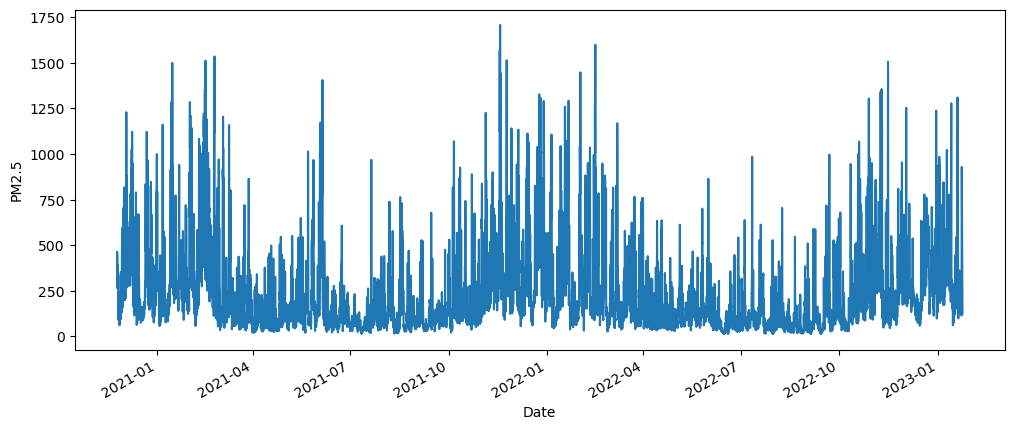

In [12]:
df["PM2.5"].plot(xlabel= "Date", ylabel= "PM2.5", figsize=(12,5));

From the ACF (Autocorrelation Function) plots below, we see that correlations are **decaying** or **decreasing** to zero very slowly, and remain well above the 95% confidence band or siginificance threshold (the blue paint). This indicates non stationarity.
However, I shall conduct a Statistical tests for Stationarity to confirm this.

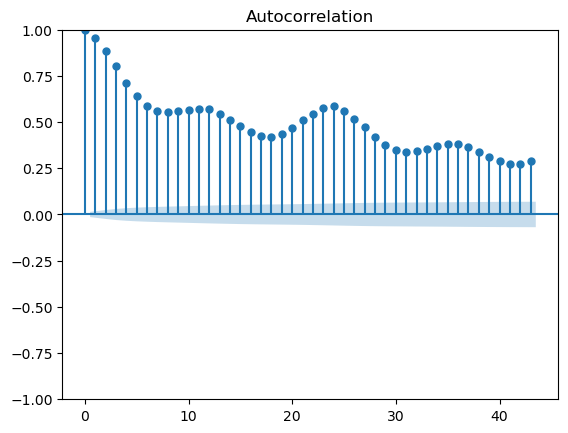

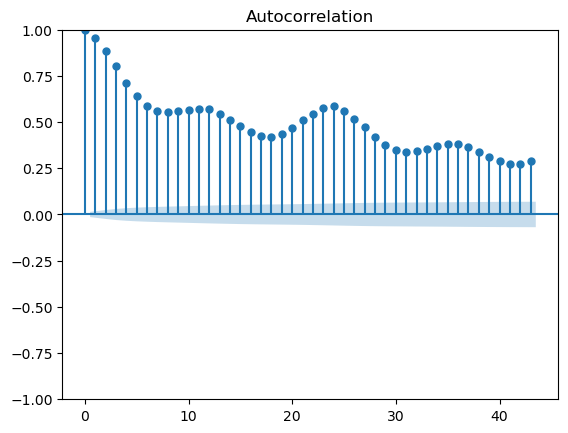

In [19]:
acf = plot_acf(df["PM2.5"])
acf

## Statistical Tests for Stationarity
#### Augmented Dickey-Fuller Test
Setting the Hypothesis. An alpha of **0.05** is used as the default (95% confidence)

1. **Ho : The time series is non-stationary**
2. **H1 : The time series is stationary**

#### Results:
Following the ADF test, we can see that the **p-value = 6.677426115512112e-17** is less that **0.05** hence we reject the null hypothesis (Ho), and conclude that the Time series is Stationary.                    

In [14]:
result  = adfuller(df["PM2.5"])
print (f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')

if result[1] < 0.05 :
    print(f'Series is Stationary')
else:
    print(f'Series is not stationary')
    

Test Statistics: -9.782452493063294
p-value: 6.677426115512112e-17
Critical values: {'1%': -3.430699164293836, '5%': -2.861694317770355, '10%': -2.5668521392325716}
Series is Stationary


#### KPSS Test
The test is based on the following hypothesis:

1. **Ho : The time series is  Stationary**
2. **H1 : The time series is not Stationary**

#### Results:
Following the KPSS test, we can see that the **p-value = 0.01** is less that **0.05** hence we reject the null hypothesis (Ho), and conclude that the Time series is not Stationary.


In [18]:
stats, p ,lags, critical_values = kpss(df["PM2.5"], "ct")
print (f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical values: {critical_values}')

if result[1] < 0.05 :
    print(f'Series is not Stationary')
else:
    print(f'Series is Stationary')

Test Statistics: 0.7883771857817479
p-value: 0.01
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


### Contradicting Results
We can see that both the statistical tests (ADF and KPSS) return different / contradicting results, whereby the **ADF returns that the Time series is Stationary** while the **KPSS returns that the Time series is Not stationary**.

In our case we conclude that our **Time series is difference stationary**. Therefore we must perform differencing so as to make the series stationary.
Also from the acf plots earlier, we saw that the correlations were decreasing very slowly to zero and remain significantly above the confidence bands, confirming that the Time series is not stationary

##### Rolling average/ Moving average
To smooth or filter out the noise the time series data
I shall use a window size 0f 12, denoting 12 months, which gives a rolling mean at yearly levels **(Annual rolling average)**.

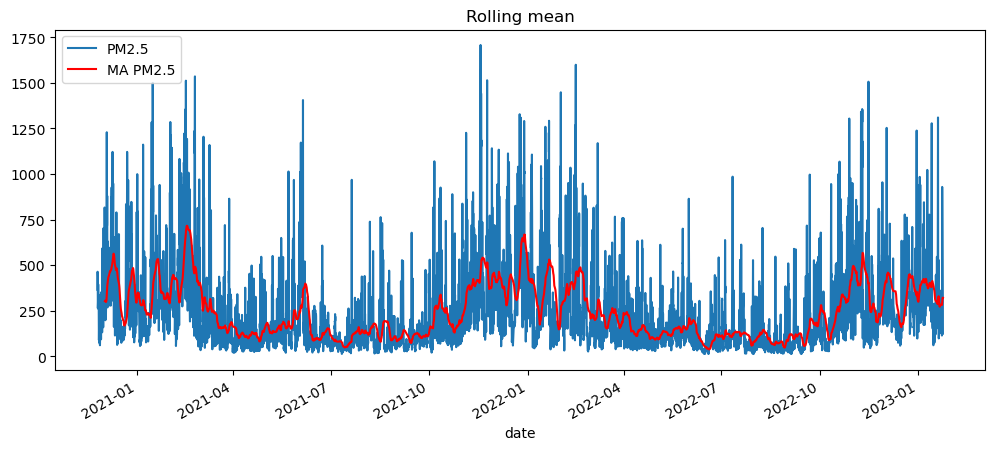

In [43]:
plt.figure(figsize=(12,5))
df["PM2.5"].plot(label= "PM2.5")
df["PM2.5"].rolling(window=168).mean().plot(label="MA PM2.5", color="red")
plt.legend()
plt.title("Rolling mean");

#### Finding the best Order for the model
Earlier we saw that the Time series data needs differencing in order to make it stationary, Therefore we shall be fitting an **ARIMA model with the I part as the order of differencing**.


In [41]:
model = auto_arima(df["PM2.5"], trace=True, suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=206610.949, Time=68.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=210599.406, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=208140.357, Time=1.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=208009.919, Time=8.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=210597.407, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=24.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=207593.293, Time=23.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=206552.024, Time=32.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=207312.714, Time=21.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=205227.482, Time=32.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=205230.547, Time=30.85 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=205176.638, Time=30.81 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=205222.810, Time=67.25 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=204625.095, Time=90.64 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18776
Model:               SARIMAX(5, 1, 3)   Log Likelihood             -102302.361
Date:                Sun, 19 Feb 2023   AIC                         204622.723
Time:                        14:26:51   BIC                         204693.286
Sample:                             0   HQIC                        204645.880
                              - 18776                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4301      0.023     62.015      0.000       1.385       1.475
ar.L2         -0.4722      0.045    -10.550      0.000      -0.560      -0.384
ar.L3         -0.1453      0.035     -4.123      0.000      -0.214      -0.076
ar.L4         -0.2777      0.012    -24.036      0.000      -0.300      -0.255
ar.L5          0.1650      0.005     30.270      0.000       0.154       0.176
ma.L1         -1.1529      0.023    -50.094      0.000      -1.198      -1.108
ma.L2          0.0367      0.038      0.954      0.340      -0.039       0.112
ma.L3          0.5160      0.022     23.338      0.000       0.473       0.559
sigma2      3234.1035     11.352    284.881      0.000    3211.853    3256.354
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):           1276511.12
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -3.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Cutoff split/ Horizontal split: Splitting the data into train and test
The first 80% of the data is the train set while the remaining is the test set

In [44]:
target = "PM2.5"
y = df[target]
cutoff = int(len(y) * 0.8)
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]
print("train data:", len(y_train))
print("test data:", len(y_test))

train data: 15020
test data: 3756


##### Fit the ARIMA(5,1,3) model

In [55]:
model =  ARIMA(y_train, order=(5,1,3)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                15020
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -81833.265
Date:                Sun, 19 Feb 2023   AIC                         163684.530
Time:                        15:42:58   BIC                         163753.084
Sample:                             0   HQIC                        163707.274
                              - 15020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3929      0.025     54.792      0.000       1.343       1.443
ar.L2         -0.4326      0.048     -8.999      0.000      -0.527      -0.338
ar.L3         -0.1462      0.037     -3.913      0.000      -0.219      -0.073
ar.L4         -0.2897      0.013    -23.057      0.000      -0.314      -0.265
ar.L5          0.1588      0.007     24.045      0.000       0.146       0.172
ma.L1         -1.1355      0.025    -44.827      0.000      -1.185      -1.086
ma.L2          0.0190      0.042      0.457      0.648      -0.063       0.101
ma.L3          0.5137      0.024     21.475      0.000       0.467       0.561
sigma2      3229.0230     12.374    260.944      0.000    3204.770    3253.276
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):           1223899.32
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -3.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Make predictions on the test data
From the "Predicted vs Test" figure, we see that the trend of dataset is not followed.

In [56]:
# From the end of the train set data
start = len(y_train)

# To the end of dataset
end = len(y_train) + len(y_test) -1     #or len(df) -1       

pred =  model.predict(start=start, end =end, typ="levels")

pred.index = df.index[start:end + 1]
pred.head()

date
2022-08-17 21:00:00    39.683675
2022-08-17 22:00:00    37.421382
2022-08-17 23:00:00    37.680279
2022-08-18 00:00:00    39.219636
2022-08-18 01:00:00    40.972412
Name: predicted_mean, dtype: float64

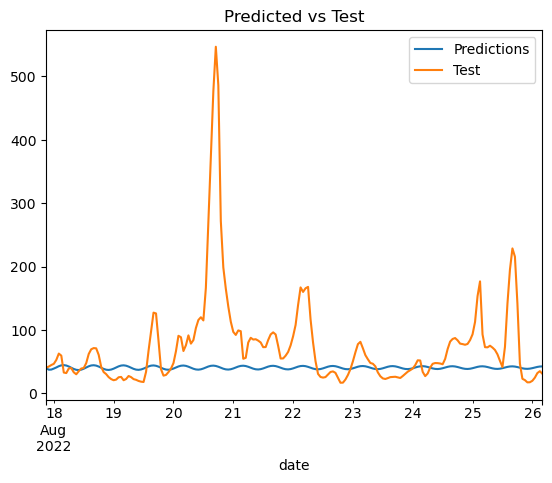

In [61]:
pred[:200].plot(label="Predictions")
y_test[:200].plot(label = "Test")
plt.legend()
plt.title("Predicted vs Test");

In [67]:
mean = y_test.mean()
mae = sqrt(mean_squared_error(pred,y_test))
print(f"Root mse:", round(mae,2))
print(f"Mean of data:", round(mean,2))

Root mse: 322.76
Mean of data: 269.69


#### Retrain the model on the entire dataset
Print the last 5 values to see on what date the dataset ends, then from there, make predictions

In [68]:
model1 = ARIMA(df, order=(5,1,3)).fit()
df.tail()

,PM2.5
date,
2023-01-24 04:00:00,231.15
2023-01-24 05:00:00,225.08
2023-01-24 06:00:00,242.49
2023-01-24 07:00:00,165.67
2023-01-24 08:00:00,123.76


#### Residuals
Residuals are what is left over after fitting a model. They are useful in checking whether the model has adequately captured the the information in the data

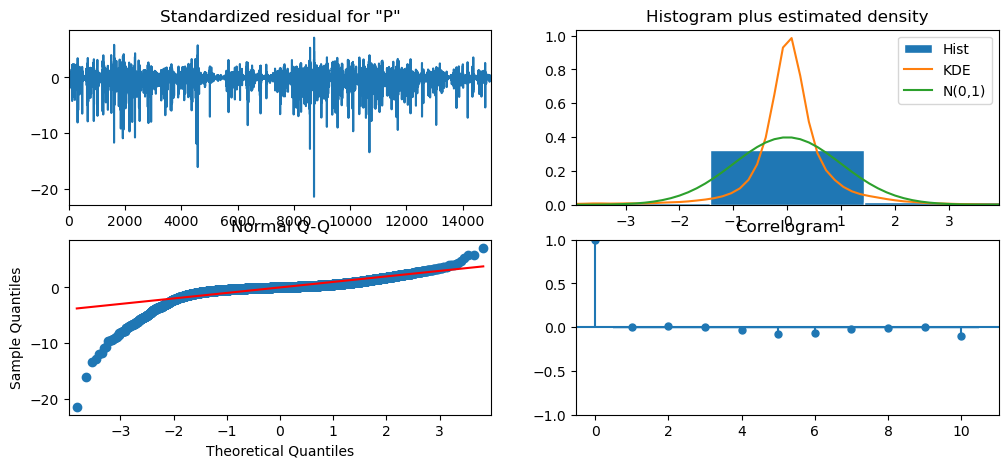

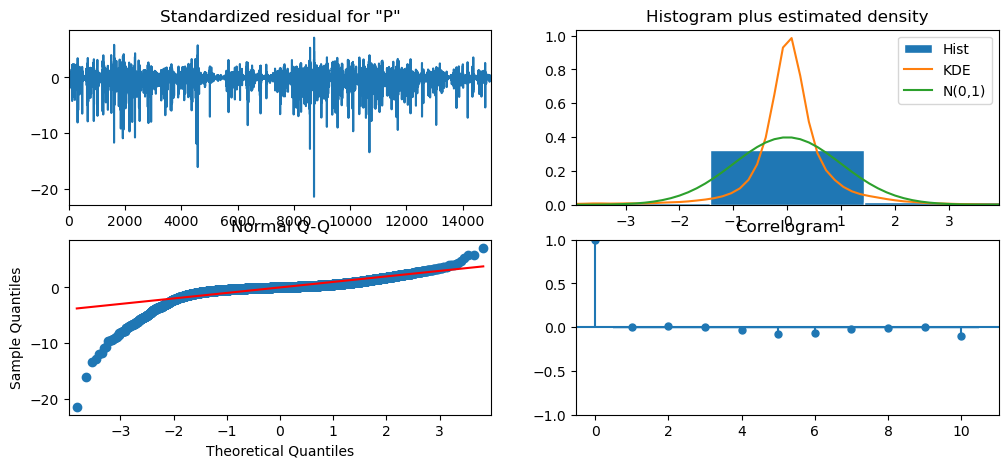

In [81]:
model.plot_diagnostics(figsize=(12,5))

#### Make predictions on the next 30 days, from the end of the dataset

In [73]:
index_future_dates = pd.date_range(start="2023-01-24 08:00:00", end="2023-02-24")
pred = model1.predict(start=len(df),end=len(df) + 30, typ="levels").rename("ARIMA predictions")
pred.index = index_future_dates
pred.head()


2023-01-24 08:00:00    116.835043
2023-01-25 08:00:00    106.710402
2023-01-26 08:00:00    124.954467
2023-01-27 08:00:00    155.794868
2023-01-28 08:00:00    187.763381
Freq: D, Name: ARIMA predictions, dtype: float64

Text(0.5, 1.0, 'Predictions for the next 30 days')

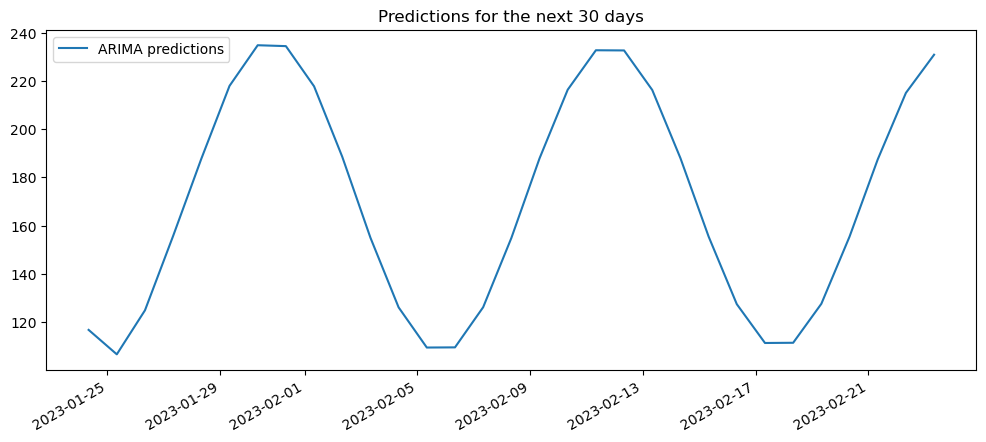

In [76]:
pred.plot(figsize=(12,5), legend=True)
plt.title("Predictions for the next 30 days")